In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from music21.midi import MidiFile, MetaEvents, getNumber, ChannelVoiceMessages
from music21.midi.translate import getTimeForEvents
from collections import namedtuple
import bisect
import sys

In [28]:
TempoEntry = namedtuple("TempoEntry", ("start_ticks", "start_ms", "microsecondsPerTick"))

def read_midi_pitches_intervals(midi_file, **kwargs):
    midi = MidiFile()
    midi.open(midi_file)
    midi.read()


    # look for set_tempo in Track0
    track0 = midi.tracks[0]
    tempos = []

    for t, ev in getTimeForEvents(track0):
        if ev.type == MetaEvents.SET_TEMPO:
            mspq = getNumber(ev.data, 3)[0]  # first data is number
            microsecondsPerTick = float(mspq) / midi.ticksPerQuarterNote
            if len(tempos) == 0:
                segment_start_ms = t * microsecondsPerTick
            else:
                segment_start_ms = tempos[-1].start_ms + (t - tempos[-1].start_ticks) * tempos[-1].microsecondsPerTick
            tempos.append(TempoEntry(t, segment_start_ms, microsecondsPerTick))

    midi.close()
    result = []

    if "midi_tracks" in kwargs:
        tracks = kwargs["midi_tracks"]
    else:
        tracks = range(len(midi.tracks))

    for track_index in tracks:
        print(f'track_index = {track_index}')
        track = midi.tracks[track_index]
        raw_events = getTimeForEvents(track)
        events = {}
        for t, ev in raw_events:
            tempo = tempos[bisect.bisect_right(tempos, t, key=lambda x: x.start_ticks) - 1]
            seconds = (tempo.start_ms + (t - tempo.start_ticks) * tempo.microsecondsPerTick) / 1e6
            if ev.type == ChannelVoiceMessages.NOTE_ON and ev.velocity > 0:
                note_key = (ev.pitch, ev.channel)
                if not note_key in events:
                    events[note_key] = [(seconds, ev.velocity)]
                else:
                    events[note_key].append((seconds, ev.velocity))
            elif ev.type == ChannelVoiceMessages.NOTE_OFF or (ev.type == ChannelVoiceMessages.NOTE_ON and ev.velocity == 0):
                note_key = (ev.pitch, ev.channel)
                if note_key in events:
                    for time, velocity in events[note_key]:
                        if seconds > time:
                            result.append([time, seconds, ev.pitch])
                    del events[note_key]
    if len(result) > 0:
        result = sorted(result, key=lambda x: x[0])
        start, end, pitches = zip(*result)
        return np.array(pitches), np.array(list(zip(start, end)))
    else:
        return np.array([]), np.empty(shape=[0,2])


def pitch_to_frames(file_name, hop = 0.0232239):
    ext = os.path.splitext(file_name)[1].lower()[1:]
    pitches, intervals = read_midi_pitches_intervals(file_name)
    # frames = np.zeros((int(np.max(intervals)/hop) + 1, max(pitches) + 1), dtype=int)
    frames = np.zeros((int(np.max(intervals)/hop) + 1, 128), dtype=int)
    print(frames.shape)
    for pitch, interval in zip(pitches, intervals):
        for i in range(int(interval[0] / hop), int(interval[1] / hop) + 1):
            frames[i][pitch] = 1
    return frames, min(pitches), max(pitches)

In [54]:
def midi_to_note_name(midi_note):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = midi_note // 12 - 1
    return f"{note_names[midi_note % 12]}{octave}"

track_index = 0
track_index = 1
(5195, 128)


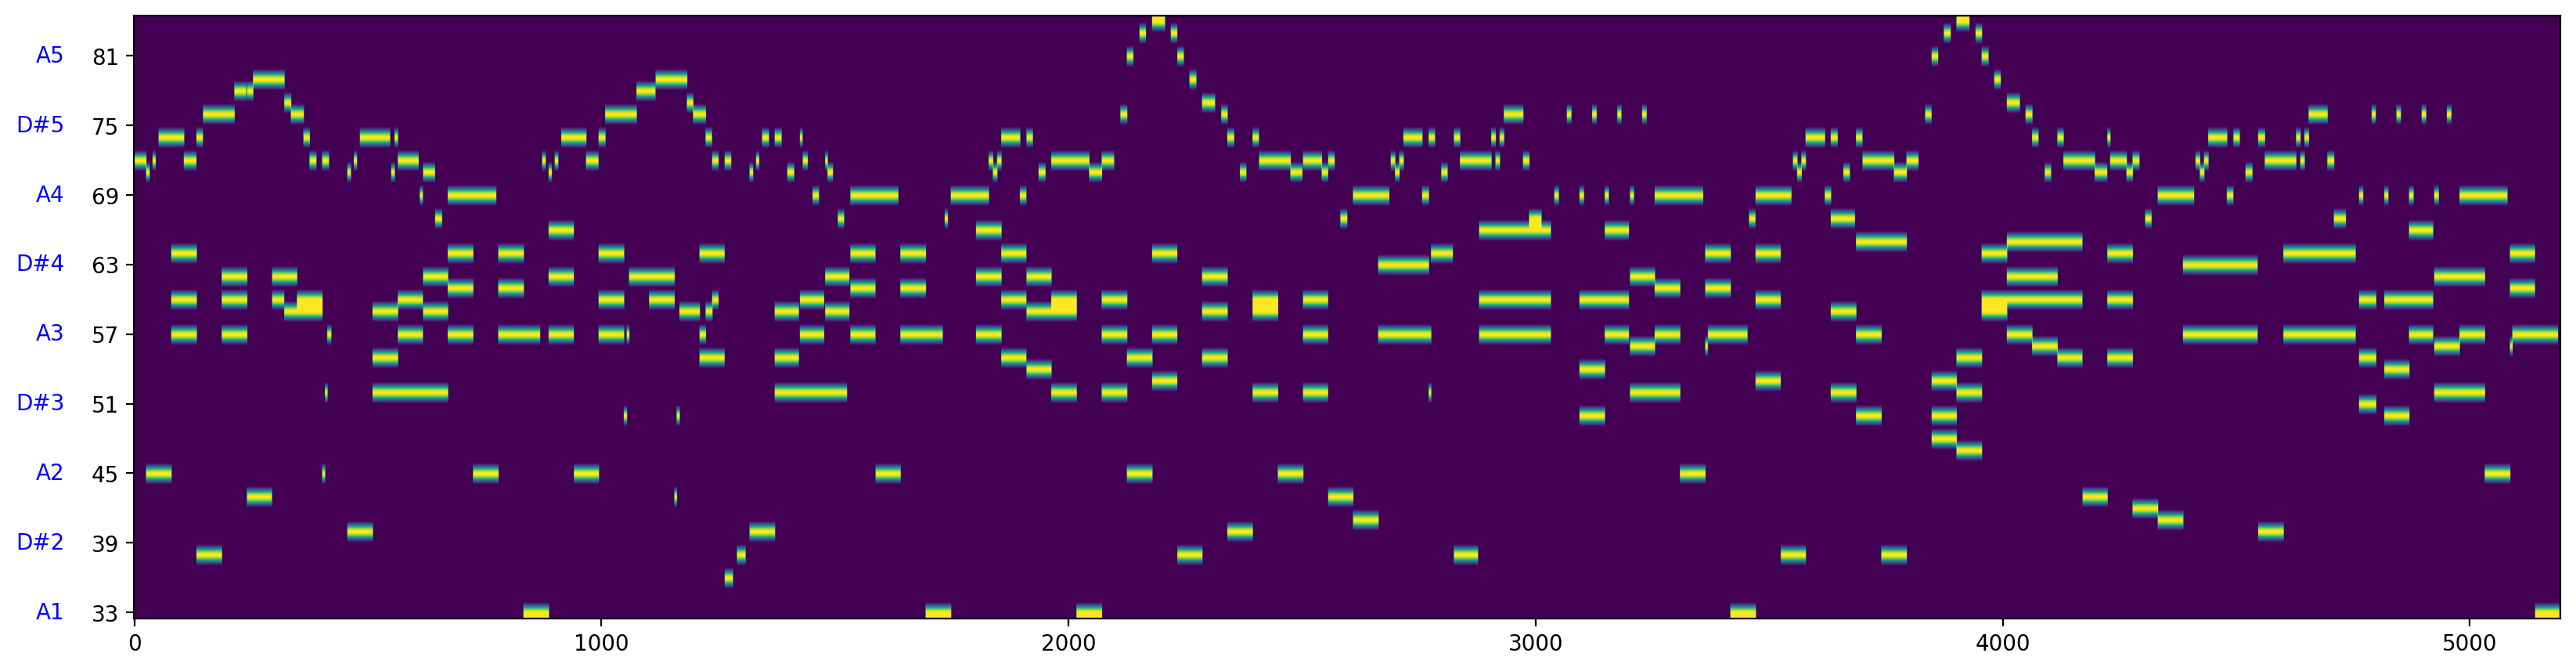

In [64]:
# Let's visualize (and create matrices for our data) 
#     from A0 (note number 21) to C7 (note number 96) 

midi_file = "./Scores/BartokRomanianDances/Romanian_Folk_Dances_-_No._1.mid"
fps=44100/512 # fps for our mel spectrogram

frames, minp, maxp = pitch_to_frames(midi_file, hop = 1/fps) #same fps as our mel spectrogram
plt.figure(figsize=(20, 5))

# generate smaller matrix with rows only for notes that are used
subset_matrix=frames.swapaxes(1,0)[minp:maxp+1, :]
plt.imshow(subset_matrix,  origin='lower', aspect='auto')

# Manually set the y-axis ticks and labels to be midi note numbers
yticks = np.arange(0, subset_matrix.shape[0], 6)  # Positions of ticks in the subset matrix
ytick_labels = np.arange(minp,maxp+1, 6)  # Original indices from the full matrix
plt.yticks(yticks, ytick_labels)

# Add text labels for note names next to each tick
for i, label in enumerate(ytick_labels):
    plt.text(-150, yticks[i], f'{midi_to_note_name(ytick_labels[i])}', va='center', ha='right', color='blue') 
plt.show()